In [1]:
import skimage as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
PATH_IMG = '../data/landmarks/aligned/before_4/'

In [3]:
df = pd.read_csv('../data/landmarks/aligned/labels/reformated_8698.csv')

In [4]:
del df['Unnamed: 0']

In [5]:
df_filenames = np.array(df['filename'])
col = df.columns
df_coord = np.array([[int(df[col[i]][j]) for i in range(1,len(col))] for j in range(len(df))])

In [6]:
idx = 0
img = sk.io.imread(PATH_IMG+df_filenames[idx])
coord = df_coord[idx]

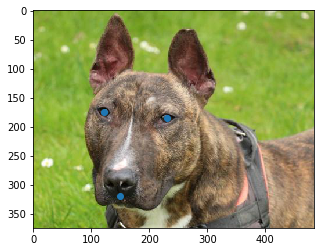

In [7]:
plt.imshow(img)
plt.plot(coord[::2],coord[1::2], 'o')
plt.show()

In [7]:
def clipping(img, coord):
    h, w, c = img.shape
    if h < w:
        bound_min = min(coord[::2])
        bound_max = max(coord[::2])
        if bound_max - bound_min > h:
            print("Shit happens sometimes... {:d} {:d} {:d}".format(bound_max, bound_min, h))
        clip = w - h
        d = bound_min
        D = w - bound_max
        left = int(d*clip/(d+D))
        right = bound_max + D - int(D*clip/(d+D))
        
        coord_add = np.copy(coord)
        coord_add[::2] -= left
        return img[:,left:right,:], np.array(coord_add)
    elif h > w:
        new_coord = []
        for i in range(3):
            new_coord += [coord[2*i+1]] + [coord[2*i]]
            
        img_T = np.transpose(img, axes=(1,0,2))
        img_clipped, coord_add = clipping(img_T, new_coord)
        
        coord_add_T = []
        for i in range(3):
            coord_add_T += [coord_add[2*i+1]] + [coord_add[2*i]]
        
        return np.transpose(img_clipped, axes=(1,0,2)), np.array(coord_add_T)
    else:
        return img, coord

In [8]:
def resize(img, coord, output_shape):
    img_resized = sk.transform.resize(img, output_shape)
    x_ratio = output_shape[0]/img.shape[0]
    y_ratio = output_shape[1]/img.shape[1]
    
    new_coord = np.zeros(6)
    for i in range(3):
        new_coord[2*i] = int(coord[2*i]*x_ratio)
        new_coord[2*i+1] = int(coord[2*i+1]*y_ratio)
    return img_resized, new_coord

(375, 376, 3)


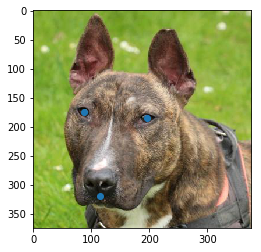

In [10]:
img_clipped, coord_clipped = clipping(img, coord)
print(img_clipped.shape)
plt.imshow(img_clipped)
plt.plot(coord_clipped[::2],coord_clipped[1::2],'o')
plt.show()

(224, 224, 3)


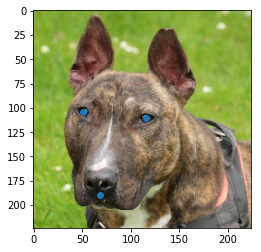

In [11]:
img_resized, coord_resized = resize(img_clipped, coord_clipped, (224,224,3))
print(img_resized.shape)
plt.imshow(img_resized)
plt.plot(coord_resized[::2],coord_resized[1::2],'o')
plt.show()

In [12]:
coord

array([122, 175, 230, 185, 149, 319])

In [13]:
def aligned_squared_bbox(img, coord):
    # Middle of the bbox: barycenter
    mean_x = np.sum(coord[::2])/3
    mean_y = np.sum(coord[1::2])/3
    
    # Size on the edge: 1.2*(barycenter-nose)
    potential_h = [np.sqrt((mean_x-coord[i])**2+(mean_y-coord[i+1])**2) for i in range(0,6,2)]
    h = 2.2 * np.max(potential_h)
    #h = 2.2 * np.sqrt((mean_x-coord[4])**2+(mean_y-coord[5])**2)
    
    # Return bbox coord (x1, y1, x2, y2)
    x1 = mean_x - h/2
    y1 = mean_y - h/2
    x2 = mean_x + h/2
    y2 = mean_y + h/2
    
    return mean_x, mean_y, x1, y1, x2, y2

In [56]:
def dist(v1,v2):
    return np.sqrt((v1[0]-v2[0])**2+(v1[1]-v2[1])**2)

In [15]:
def aligned_squared_bbox(img, coord):
    # Middle of the bbox: barycenter
    mean_x = np.sum(coord[::2])/3
    mean_y = np.sum(coord[1::2])/3
    
    # Size on the edge: 1.2*(barycenter-nose)
    potential_h = [dist([coord[i],coord[i+1]],[coord[i+2],coord[i+3]]) for i in range(-2,6,4)]
    h = 1.5 * np.max(potential_h)
    #h = 2.2 * np.sqrt((mean_x-coord[4])**2+(mean_y-coord[5])**2)
    
    # Return bbox coord (x1, y1, x2, y2)
    x1 = mean_x - h/2
    y1 = mean_y - h/2
    x2 = mean_x + h/2
    y2 = mean_y + h/2
    
    return mean_x, mean_y, x1, y1, x2, y2

In [16]:
def aligned_squared_bbox(img, coord):
    # Middle of the bbox: barycenter
    mean_x = np.sum(coord[::2])/3
    mean_y = np.sum(coord[1::2])/3
    
    # Size on the edge: 1.2*(barycenter-nose)
    h = 2.2 * np.sqrt((coord[0]-coord[2])**2+(coord[1]-coord[3])**2)
    
    # Return bbox coord (x1, y1, x2, y2)
    x1 = mean_x - h/2
    y1 = mean_y - h/2
    x2 = mean_x + h/2
    y2 = mean_y + h/2
    
    return mean_x, mean_y, x1, y1, x2, y2

In [21]:
a = np.array(coord[[0,1]])
b = np.array(coord[[2,3]])
c = np.array(coord[[4,5]])

A = np.array([(a - c).T, (b - a).T])

In [22]:
A

array([[-330, -936],
       [ 475,  104]])

In [23]:
A.dot([0,1])

array([-936,  104])

In [35]:
A[0].dot((a+c)/2)

-1313736.0

In [34]:
# Middle of the bbox: barycenter
a = np.array(coord[[0,1]])
b = np.array(coord[[2,3]])
c = np.array(coord[[4,5]])

A = np.array([(a - c).T, (b - a).T])
b = [A[0].dot((a+c)/2),A[1].dot((b+a)/2)]
print(A)
print(b)

mean = np.linalg.solve(A,b)
print(mean)

# Size on the edge: 1.2*(barycenter-nose)
#h = 2.2 * np.sqrt((coord[0]-coord[2])**2+(coord[1]-coord[3])**2)
h = 2.2 * np.sqrt((coord[0]-mean[0])**2+(coord[1]-mean[1])**2)

# Return bbox coord (x1, y1, x2, y2)
x1 = mean[0] - h/2
y1 = mean[1] - h/2
x2 = mean[0] + h/2
y2 = mean[1] + h/2

mean[0], mean[1], x1, y1, x2, y2

[[-330 -936]
 [ 475  104]]
[-1313736.0, 643857.5]
[1135.8634981  1003.09940772]


(1135.8634980988593,
 1003.0994077215558,
 589.5001527309971,
 456.7360623536937,
 1682.2268434667214,
 1549.4627530894181)

In [72]:
np.linalg.norm(a)

1122.8824515504728

In [69]:
def aligned_squared_bbox(img, coord):
    # Middle of the bbox: barycenter
    a = np.array(coord[[0,1]])
    b = np.array(coord[[2,3]])
    c = np.array(coord[[4,5]])
    
    ab = b-a
    ca = a-c
    
    A = np.array([ca.T, ab.T])
    b = [A[0].dot((a+c)/2),A[1].dot((b+a)/2)]
    
    # Center of the circumscribed circle
    mean_o = np.linalg.solve(A,b)
    
    # Move it up or down depending on the nose position
    # Computes nose projection on eyes segment
    ck = ca + ab.dot(ac) * ab/np.linalg.norm(ab)**2
    # Computes high length
    nose_h = np.linalg.norm(ck)
    
    
    
#     h = 3. * np.sqrt((coord[0]-mean_o[0])**2+(coord[1]-mean_o[1])**2)
    
#     mean_i = np.array([np.sum(coord[::2])/3, np.sum(coord[1::2])/3])
    
#     inner_mean = mean_o - mean_i
    
#     mean_o = mean_o + 1.0*inner_mean
    
    # Size on the edge: 1.2*(barycenter-nose)
    h = 2.2 * np.sqrt((coord[0]-coord[2])**2+(coord[1]-coord[3])**2)
    
    
    # Return bbox coord (x1, y1, x2, y2)
    x1 = mean_o[0] - h/2
    y1 = mean_o[1] - h/2
    x2 = mean_o[0] + h/2
    y2 = mean_o[1] + h/2
    
    return mean_o[0], mean_o[1], x1, y1, x2, y2

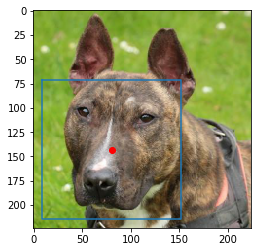

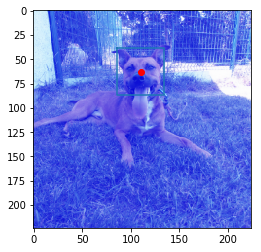

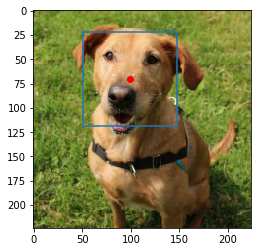

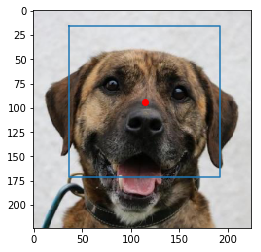

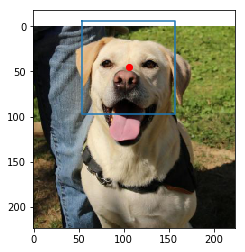

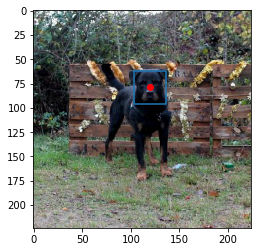

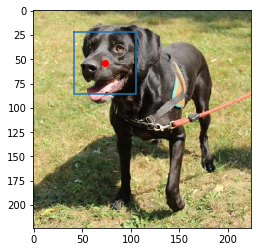

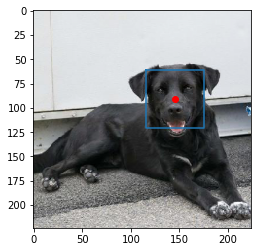

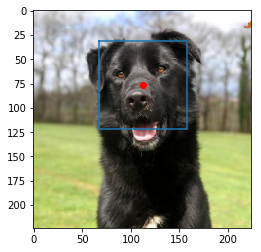

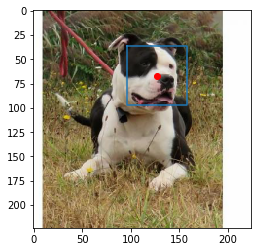

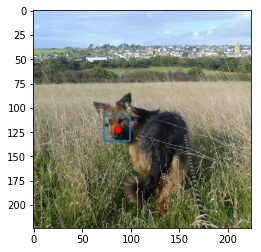

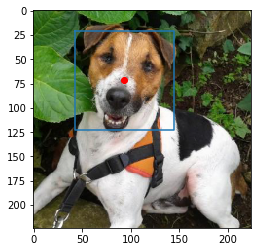

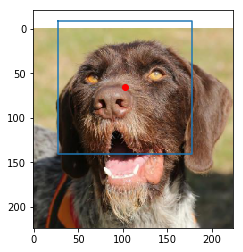

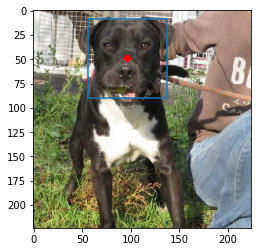

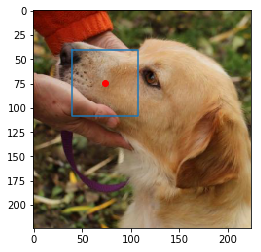

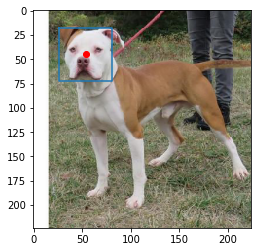

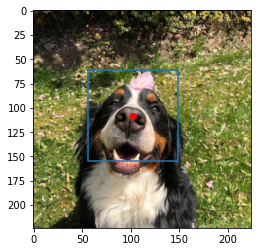

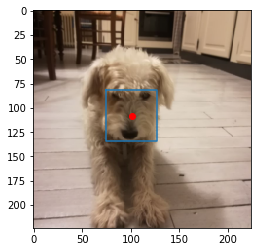

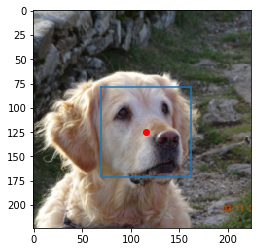

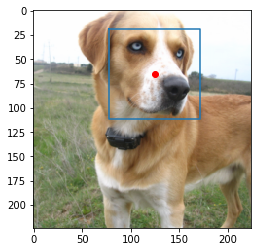

In [70]:
idx = 0
for idx in range(0,1000,51):
    img = sk.io.imread(PATH_IMG+df_filenames[idx])
    coord = df_coord[idx]

    img_clipped, coord_clipped = clipping(img, coord)

    img_resized, coord_resized = resize(img_clipped, coord_clipped, (224,224,3))

    mx, my, x1, y1, x2, y2 = aligned_squared_bbox(img_resized, coord_resized)

    plt.imshow(img_resized)
    plt.plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1])
    plt.plot([mx],[my], 'ro')
    plt.show()

## New methods with neural networks

In [9]:
import keras
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


### Model definition and training

In [ ]:
# TranslationMatrix * RotationMatrix * ScaleMatrix 

In [47]:
def rotation_matrix_np(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(theta / 2.0)
    b, c, d = -axis * np.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

In [18]:
def rotation_matrix(theta, axis):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = axis / K.sqrt(K.sum(K.square(axis),axis=-1,keepdims=True))
    a = K.cos(theta / 2.0)
    b, c, d = -axis * K.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return K.constant([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                       [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                       [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

In [37]:
# Model cost:
# It will use the output to rotate, translate a mask
# The mask will be projected in 2D and it will thus gives a 6D vector
# A MSE is then computed

def transform_mse(y_true, y_pred):
    y_pred = K.mean(y_pred, axis=-0)
    R = rotation_matrix(y_pred[0], y_pred[1:4])
    t = y_pred[4:7]
    s = y_pred[7]
    
    mask = K.constant([[0,0,0],[1,0,0],[.5,-1,0]]).T
    # Transformation: rotation, translation, scaling
    out = s * K.dot(R,mask) + t
    # Projection
    Projection = K.constant([[1,0,0],[0,0,1]])
    out = K.dot(Projection, out)
    
    out = K.flatten(out.T)
    
    return K.sum(K.square(out-K.mean(y_true,axis=0)))

New try with quaternions

With numpy

In [10]:
def angle_axis_quat_np(theta, axis):
    """
    Given an angle and an axis, it returns a quaternion.
    """
    axis = np.array(axis) / np.linalg.norm(axis)
    return np.append([np.cos(theta/2)],np.sin(theta/2) * axis)

In [11]:
def mult_quat_np(q1, q2):
    """
    Quaternion multiplication.
    """
    q3 = np.copy(q1)
    q3[0] = q1[0]*q2[0] - q1[1]*q2[1] - q1[2]*q2[2] - q1[3]*q2[3]
    q3[1] = q1[0]*q2[1] + q1[1]*q2[0] + q1[2]*q2[3] - q1[3]*q2[2]
    q3[2] = q1[0]*q2[2] - q1[1]*q2[3] + q1[2]*q2[0] + q1[3]*q2[1]
    q3[3] = q1[0]*q2[3] + q1[1]*q2[2] - q1[2]*q2[1] + q1[3]*q2[0]
    return q3

In [12]:
def rotate_quat_np(quat, vect):
    """
    Rotate a vector with the rotation defined by a quaternion.
    """
    # Transfrom vect into an quaternion 
    vect = np.append([0],vect)
    # Normalize it
    norm_vect = np.linalg.norm(vect)
    if norm_vect:
        vect = vect/norm_vect
    # Computes the conjugate of quat
    quat_ = np.append(quat[0],-quat[1:])
    # The result is given by: quat * vect * quat_
    res = mult_quat_np(quat, mult_quat_np(vect,quat_)) * norm_vect
    #res = np.dot(mat_quat_np(quat), np.dot(mat_quat_np(vect),quat_)) * norm_vect
    return res[1:]

In [51]:
v = [3, 5, 0]
axis = [4, 4, 1]
theta = 1.2 

print(np.dot(rotation_matrix_np(axis, theta), v)) 
print(rotate_quat_np(angle_axis_quat_np(theta, axis), v))

[2.74911638 4.77180932 1.91629719]
[2.74911638 4.77180932 1.91629719]


In [98]:
v = [0,-1,1]
axis = [0,1,0]
theta = 0.2

print(np.dot(rotation_matrix_np(axis, theta), v)) 
print(rotate_quat_np(np.array([1.,0,0,0]), v))

[ 0.19866933 -1.          0.98006658]
[ 0. -1.  1.]


In [50]:
angle_axis_quat_np(theta, axis)

array([1., 0., 0., 0.])

Different try to use Keras structures: Keras does not support item assignment

In [12]:
def mat_quat(q):
    """
    Given a quaternion, return its multiplication matrix
    """
    return np.array([[q[0],-q[1],-q[2],-q[3]],
                   [q[1], q[0],-q[3], q[2]],
                   [q[2], q[3], q[0],-q[1]],
                   [q[3],-q[2], q[1], q[0]]])

In [34]:
def mat_quat(q):
    """
    Given a quaternion, return its multiplication matrix
    """
    coord = np.array([
        [1,0,0,0],
        [0,-1,0,0],
        [0,0,-1,0],
        [0,0,0,-1],
        [0,1,0,0],
        [1,0,0,0],
        [0,0,0,-1],
        [0,0,1,0],
        [0,0,1,0],
        [0,0,0,1],
        [1,0,0,0],
        [0,-1,0,0],
        [0,0,0,1],
        [0,0,-1,0],
        [0,1,0,0],
        [1,0,0,0]
    ])
    return np.reshape(np.dot(coord,q),(4,4))

In [ ]:
def mat_quat(q):
    """
    Given a quaternion, return its multiplication matrix
    """
    return K.constant([[q[0],-q[1],-q[2],-q[3]],
                       [q[1], q[0],-q[3], q[2]],
                       [q[2], q[3], q[0],-q[1]],
                       [q[3],-q[2], q[1], q[0]]])

In [10]:
def mat_quat(q):
    """
    Given a quaternion, return its multiplication matrix
    """
    coord=K.constant([
        [1,0,0,0],
        [0,-1,0,0],
        [0,0,-1,0],
        [0,0,0,-1],
        [0,1,0,0],
        [1,0,0,0],
        [0,0,0,-1],
        [0,0,1,0],
        [0,0,1,0],
        [0,0,0,1],
        [1,0,0,0],
        [0,-1,0,0],
        [0,0,0,1],
        [0,0,-1,0],
        [0,1,0,0],
        [1,0,0,0]
    ], dtype=K.floatx())
    return K.reshape(K.dot(coord,K.expand_dims(q,-1)),(4,4))

def mult_quat_l(q1, q2):
    """
    Quaternion multiplication.
    q1 is not a list
    """
    return K.dot(q2,K.transpose(mat_quat(q1)))

def mult_quat(q1, q2):
    """
    Quaternion multiplication on a batch.
    """
    qs = K.concatenate((q1,q2),axis=-1)
    # Keras multiplication is only supported for matrix multiplication
    # Hence we have to use expand_dims and squeeze function successively
    return K.map_fn(lambda qs: K.squeeze(K.dot(mat_quat(qs[:4]),K.expand_dims(qs[4:],-1)),-1),qs)

def rotate_quat(quat, vect):
    """
    Rotate a vector with the rotation defined by a quaternion.
    """
    # Normalize it
    norm_vect = K.sqrt(K.sum(K.square(vect),axis=-1,keepdims=True))
#     if K.equal(norm_vect,0):
#         return vect
    vect = vect/norm_vect
    # Normalize quat
    quat = quat / K.sqrt(K.sum(K.square(quat),axis=-1,keepdims=True))
    # Computes the conjugate of quat
    quat_ = K.concatenate((quat[:,:1],-quat[:,1:]), axis=-1)
    # The result is given by: quat * vect * quat_
    res = mult_quat(quat, mult_quat_l(vect,quat_)) * norm_vect
#     print(res.shape)
    return res[:,1:]

In [11]:
# Model cost:
# It will use the output to rotate, translate a mask
# The mask will be projected in 2D and it will thus gives a 6D vector
# A MSE is then computed

def transform_mse(y_true, y_pred):
    q = y_pred[:,:4]
    t = y_pred[:,4:7]
    s = y_pred[:,7:]
    
    outputs = []
    extras = []
    projection = K.constant([[1,0],[0,1],[0,0]])
    projection_z = K.constant([[0],[0],[1]])
    for mask in [[0,0,0,0],[0,1,0,0],[0,.5,-1.5,0]]:
        if np.linalg.norm(mask)==0:
            output = t
        else:
            output = s * rotate_quat(q,K.constant(mask)) + t
        extras = extras + [K.dot(output,projection_z)]
        output = K.dot(output,projection)
        outputs = outputs + [output]
        
    outputs = K.concatenate(outputs, axis=-1)
    extras = K.concatenate(extras, axis=-1)

    # We check that the nose is in the front (it is the case in most of the pictures)
    extras_1 = K.min(extras[:,:2])
    extras_2 = extras[:,2]
    extras_out = tf.where(K.less(extras_2,extras_1), x=K.ones_like(extras), y=K.zeros_like(extras))

    return 10000*keras.losses.mean_squared_error(y_true, outputs) + K.sum(extras_out)/100

In [12]:
PATH_SAVE = '../output/model/2019.07.01/transform_8.h5'
model = keras.models.load_model(PATH_SAVE, custom_objects={'transform_mse':transform_mse})

In [42]:
# Model definition
# It takes as input a 6D vector: [lex, ley, rex, rey, nox, noy]
# It ouputs a 8D vector: [theta, axis[0], axis[1], axis[2], tx, ty, tz, scale] <- [rotation, translation, scale]

model = keras.models.Sequential()
model.add(keras.layers.Dense(8,input_shape=(6,)))
# model.add(keras.layers.BatchNormalization())
# model.add(keras.layers.Dense(8))

In [57]:
model.compile('adam',loss=transform_mse)

In [44]:
df_coord_ = df_coord / np.sqrt(np.sum(np.square(df_coord),axis=-1,keepdims=True))

In [79]:
model.fit(df_coord_,df_coord_,batch_size=256,epochs=20,validation_split=0.1)

Train on 7828 samples, validate on 870 samples
Epoch 1/20
7828/7828 [==============================] - 6s 807us/step - loss: 1.6096 - val_loss: 1.3829
Epoch 2/20
7828/7828 [==============================] - 6s 800us/step - loss: 1.5990 - val_loss: 1.3888
Epoch 3/20
7828/7828 [==============================] - 7s 852us/step - loss: 1.5944 - val_loss: 1.3672
Epoch 4/20
7828/7828 [==============================] - 6s 808us/step - loss: 1.5896 - val_loss: 1.3742
Epoch 5/20
7828/7828 [==============================] - 6s 798us/step - loss: 1.5878 - val_loss: 1.3752
Epoch 6/20
7828/7828 [==============================] - 6s 802us/step - loss: 1.5855 - val_loss: 1.3831
Epoch 7/20
7828/7828 [==============================] - 6s 806us/step - loss: 1.5717 - val_loss: 1.3625
Epoch 8/20
7828/7828 [==============================] - 6s 823us/step - loss: 1.5677 - val_loss: 1.3751
Epoch 9/20
7828/7828 [==============================] - 6s 799us/step - loss: 1.5645 - val_loss: 1.3691
Epoch 10/20
7828/

In [80]:
model.save('../output/model/2019.07.01/transform_8.h5')

In [94]:
A,b = model.layers[0].get_weights()

In [98]:
np.save('../output/model/2019.07.01/transform_8.npy', (A,b))

In [103]:
A_,b_ = np.load('../output/model/2019.07.01/transform_8.npy', allow_pickle=True)

In [107]:
b_

array([-0.01956358,  0.05305202,  0.01559347, -0.1411001 ,  0.03508957,
        0.0346183 ,  0.        ,  0.02556852], dtype=float32)

In [33]:
import tensorflow as tf

n=8
# coords = []
# for idx in range(0,51*8,51):
#     img = sk.io.imread(PATH_IMG+df_filenames[idx])
#     coord = df_coord[idx]
    

#     img_clipped, coord_clipped = clipping(img, coord)

#     _, coord_resized = resize(img_clipped, coord_clipped, (224,224,3))
    
#     coords += [coord_resized]
# coords = np.array(coords)
# coords = coords/np.sqrt(np.sum(np.square(coords),axis=-1,keepdims=True))
coords = df_coord[:n]/np.sqrt(np.sum(np.square(df_coord[:n]),axis=-1,keepdims=True))
# coords = df_coord[:n]
y_true = K.constant(coords[:n])
y_pred = K.constant(model.predict(coords[:n]))

q = y_pred[:,:4]
t = y_pred[:,4:7]
s = y_pred[:,7:]

outputs = []
projection = K.constant([[1,0],[0,1],[0,0]])
for mask in [[0,0,0,0],[0,1,0,0],[0,.5,-1,0]]:
    if np.linalg.norm(mask)==0:
        output = t
    else:
        output = s * rotate_quat(q,K.constant(mask)) + t
    output = K.dot(output,projection)
    outputs = outputs + [output]

outputs_ = K.concatenate(outputs, axis=-1)

loss = keras.losses.mean_squared_error(y_true, outputs_)
with tf.Session() as sess:
    
    print(sess.run([y_pred, y_true, outputs_,loss]))

[array([[ 0.61584556,  0.25192076, -1.0615134 , -0.28008378,  0.27107254,
         0.13488086, -0.24810366, -0.3768717 ],
       [ 0.6358564 ,  0.17491402, -1.1071044 , -0.23259674,  0.35996252,
         0.18876062, -0.08240362, -0.35751793],
       [ 0.6265223 ,  0.0269852 , -1.157569  , -0.02572136,  0.5272189 ,
         0.24377368,  0.37743282, -0.06971855],
       [ 0.64610887,  0.20984519, -1.1172194 , -0.22961439,  0.3485295 ,
         0.17025965, -0.09799804, -0.31108606],
       [ 0.6545202 ,  0.11341337, -1.1584486 , -0.11053532,  0.47033006,
         0.18692714,  0.18956046, -0.1820031 ],
       [ 0.65642524,  0.12957308, -1.1637304 , -0.13325265,  0.4489652 ,
         0.18662478,  0.13054979, -0.20801075],
       [ 0.64643115,  0.14338216, -1.1401806 , -0.14455546,  0.44592866,
         0.18556517,  0.14058988, -0.19734491],
       [ 0.63688654,  0.04677963, -1.1593392 , -0.05884098,  0.5127669 ,
         0.23839761,  0.3170306 , -0.12322976]], dtype=float32), array([[0.2408

### Evaluation

In [26]:
def mult_quat_np(q1, q2):
    """
    Quaternion multiplication.
    """
    q3 = np.copy(q1)
    q3[0] = q1[0]*q2[0] - q1[1]*q2[1] - q1[2]*q2[2] - q1[3]*q2[3]
    q3[1] = q1[0]*q2[1] + q1[1]*q2[0] + q1[2]*q2[3] - q1[3]*q2[2]
    q3[2] = q1[0]*q2[2] - q1[1]*q2[3] + q1[2]*q2[0] + q1[3]*q2[1]
    q3[3] = q1[0]*q2[3] + q1[1]*q2[2] - q1[2]*q2[1] + q1[3]*q2[0]
    return q3

def rotate_quat_np(quat, vect):
    """
    Rotate a vector with the rotation defined by a quaternion.
    """
    # Transfrom vect into an quaternion 
    vect = np.append([0],vect)
    # Normalize it
    norm_vect = np.linalg.norm(vect)
    vect = vect/norm_vect
    
    quat = quat/np.linalg.norm(quat)
    # Computes the conjugate of quat
    quat_ = np.append(quat[0],-quat[1:])
    # The result is given by: quat * vect * quat_
    res = mult_quat_np(quat, mult_quat_np(vect,quat_)) * norm_vect
    return res[1:]


def transform(x, model_output):
    """
    Takes a 3D points x and outputs its transform coordinate using model_ouput.
    """
    q = model_output[:4]
    t = model_output[4:7]
    s = model_output[7:]
    
    projection = np.array([[1,0],[0,1],[0,0]])
    
    if np.linalg.norm(x)==0:
        output = t
    else:
        output = s * rotate_quat_np(q,x) + t
    output = np.dot(output,projection)
    
    return output

In [33]:
pred

array([ 36.540333,  20.916164, -57.8116  , -96.13319 , 109.02948 ,
       -93.18655 ,  40.423096, -51.681385], dtype=float32)

In [13]:
def transform(x, model_output):
    y_pred = K.constant(model_output)
    y_pred = K.expand_dims(y_pred,0)
    q = y_pred[:,:4]
    t = y_pred[:,4:7]
    s = y_pred[:,7:]
    
    if np.linalg.norm(x)==0:
        out = t
    else:
        out = s * rotate_quat(q,K.constant(x)) + t
    
    out = K.dot(out,K.constant([[1,0],[0,1],[0,0]]))
    with tf.Session() as sess:
        return sess.run(out)[0]

[ 55.54148574 133.00488085   3.46624195 -23.34136126  71.84558258
 108.80230698 -79.88887613  29.56443457]


KeyboardInterrupt: 

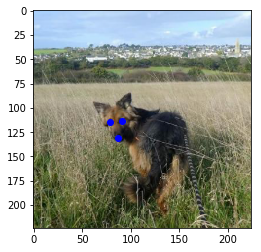

In [103]:
idx = 0
for idx in range(51*10,51*16,51):
    img = sk.io.imread(PATH_IMG+df_filenames[idx])
    coord = df_coord[idx]
    

    img_clipped, coord_clipped = clipping(img, coord)

    img_resized, coord_resized = resize(img_clipped, coord_clipped, (224,224,3))
    coord_resized_norm = np.sqrt(np.sum(np.square(coord_resized),axis=-1,keepdims=True))
    coord_resized = coord_resized/coord_resized_norm
    pred = model.predict([[coord_resized]])[0] * coord_resized_norm
    coord_resized = coord_resized*coord_resized_norm
    print(pred)
    plt.imshow(img_resized)
    plt.plot(coord_resized[::2], coord_resized[1::2],'bo')
    for x in [[0,0,0,0],[0,1,0,0],[0,.5,-1,0]]:
        y = transform(x, pred)
        plt.plot(y[0],y[1],'ro')
    x = [0,1.0,0,1.]
    y = transform(x, pred)
    plt.plot(y[0],y[1],'ko')
    plt.show()

[ 4.4208482e-02 -1.1139095e-01  3.0731317e-04  1.9939244e-04
  3.0610842e-01  4.4396937e-01  1.4579608e-01  6.2817320e-02]


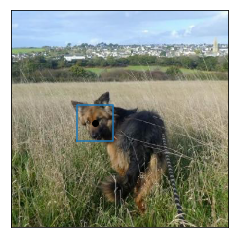

[ 0.13981873 -0.34084356 -0.0305537   0.00205304  0.35835868  0.23973131
  0.2547617   0.2183361 ]


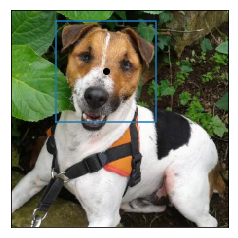

[ 0.1587322  -0.34823814 -0.02340642 -0.04140069  0.36213964  0.23344138
  0.27961373  0.24022555]


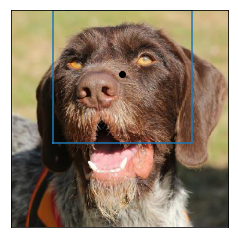

[ 0.1215007  -0.27873856 -0.00817304 -0.00392015  0.42202395  0.18808806
  0.17816265  0.18282518]


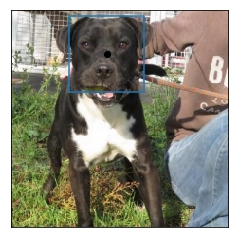

[ 0.09321429 -0.12659734 -0.18951273 -0.15873356  0.5400452   0.22480598
  0.06983847  0.07951349]


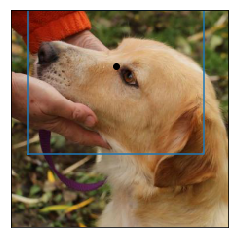

[ 0.11290281 -0.24075054 -0.01254169 -0.00707249  0.35941422  0.31567934
  0.21356535  0.16093867]


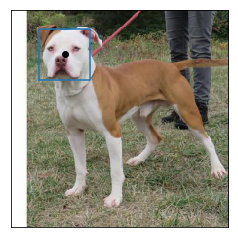

[ 0.09626492 -0.20007692 -0.017758    0.0025952   0.33289003  0.3690165
  0.20418614  0.13160408]


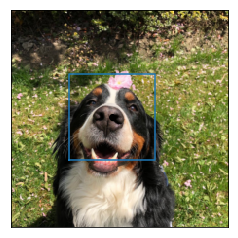

[ 0.08049946 -0.2443964  -0.0020566  -0.00376917  0.33119375  0.34689257
  0.19545665  0.14159685]


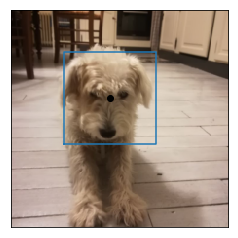

[ 0.08452497 -0.20120625  0.0307673   0.04224308  0.3255285   0.35152385
  0.18743789  0.12890801]


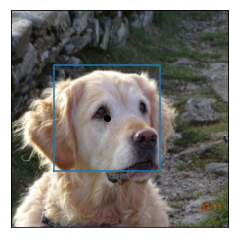

[ 0.11602108 -0.2850361   0.01738412  0.05158921  0.40968537  0.14982775
  0.16400845  0.1829893 ]


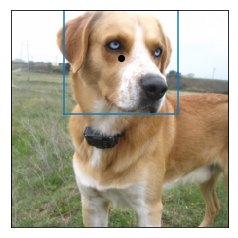

[ 0.10435216 -0.20076759  0.05314581  0.05130292  0.38518965  0.2467626
  0.16057591  0.14554387]


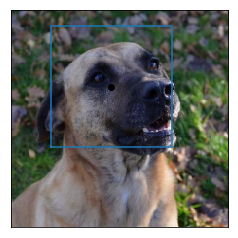

[ 0.08596633 -0.2614089   0.02636411 -0.00290756  0.3117174   0.34629616
  0.21488199  0.1582281 ]


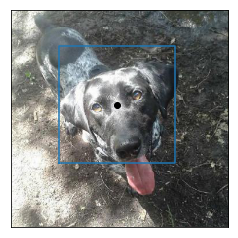

[ 0.11524475 -0.21408506 -0.00910481  0.01274933  0.4378922   0.20915914
  0.14930442  0.14943002]


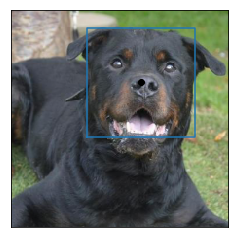

[ 0.09791686 -0.20866863  0.01156748  0.02046247  0.41792452  0.24015191
  0.14319661  0.13771015]


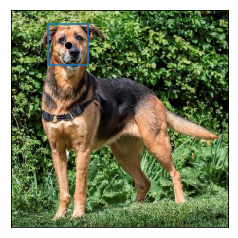

[ 0.13330276 -0.2509839  -0.01738742  0.02053256  0.39481002  0.2440742
  0.20611398  0.17624858]


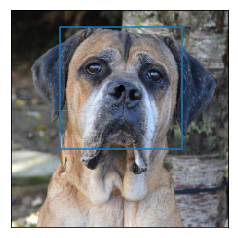

[ 0.10957982 -0.2739289  -0.00901901 -0.00512652  0.32595736  0.32926527
  0.23562507  0.17393473]


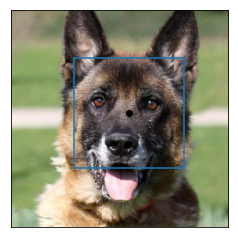

[ 0.09975623 -0.21083684 -0.00777577  0.01642232  0.42616254  0.23856992
  0.14232366  0.13647476]


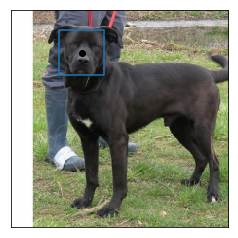

[ 0.1605579  -0.2842093   0.01009542  0.01349832  0.37059528  0.22174966
  0.25217348  0.21688712]


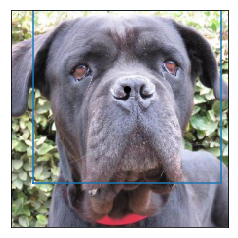

[ 0.11153458 -0.30835086  0.00559623 -0.00456513  0.2703968   0.35432875
  0.27554274  0.19460289]


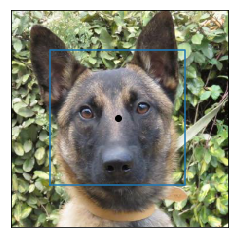

[ 0.11595412 -0.26506686 -0.00323655  0.0048597   0.31898463  0.33456787
  0.24360289  0.17539978]


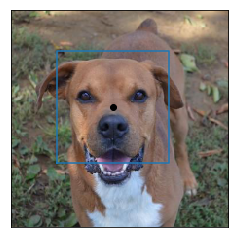

[ 0.12334909 -0.29406682 -0.01163988  0.00115405  0.38035202  0.24423113
  0.21500112  0.1896928 ]


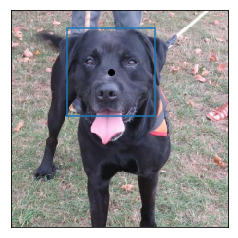

In [15]:
def dist(v1,v2):
    return np.sqrt((v1[0]-v2[0])**2+(v1[1]-v2[1])**2)

def cube(q,t,s):
    """
    Transform a cube in 3D space and plot it in 2D.
    """
    c = np.array([
        [0.,0,0],
        [1,0,0],
        [1,0,1],
        [0,0,1],
        [0,-1,0],
        [1,-1,0],
        [1,-1,1],
        [0,-1,1]
    ])
    for i in range(len(c)):
        if np.linalg.norm(q)==0:
            c[i] = t
        else:
            q = q/np.linalg.norm(q)
            c[i] = s * rotate_quat_np(q,c[i]) + t
            
        #c[i] = s * np.dot(rotation_matrix_np(axis,theta),c[i]) + t
    c = np.dot(c,np.array([[1,0],[0,1],[0,0]]))
    print(c)
    for c_e in c:
        plt.plot(c_e[0],c_e[1],'ro')
    # Front face
    plt.plot(c[2][0],c[2][1],'o', color='pink')
    plt.plot(c[3][0],c[3][1],'o', color='pink')
    plt.plot(c[6][0],c[6][1],'o', color='pink')
    plt.plot(c[7][0],c[7][1],'o', color='pink')
    
    segments = np.array([
        [c[0],c[1]],
        [c[1],c[2]],
        [c[2],c[3]],
        [c[3],c[0]],
        [c[4],c[5]],
        [c[5],c[6]],
        [c[6],c[7]],
        [c[7],c[4]],
        [c[0],c[4]],
        [c[1],c[5]],
        [c[2],c[6]],
        [c[3],c[7]]
    ])
    segments = np.reshape(segments, (12,4))
    for element in segments:
        plt.plot(element[[0,2]],element[[1,3]],'b')


for idx in range(51*10,51*31,51):
    img = sk.io.imread(PATH_IMG+df_filenames[idx])
    coord = df_coord[idx]
    

    img_clipped, coord_clipped = clipping(img, coord)

    img_resized, coord_resized = resize(img_clipped, coord_clipped, (224,224,3))
    coord_resized_norm = np.sqrt(np.sum(np.square(coord_resized),axis=-1,keepdims=True))
    coord_resized = coord_resized/coord_resized_norm
    pred = model.predict([[coord_resized]])[0]
    print(pred)
#     pred = np.dot(coord_resized,A)+b
    
    pred = pred * coord_resized_norm
    #cube(pred[:4],pred[4:7],pred[7])
    coord_resized = coord_resized*coord_resized_norm
    
    plt.imshow(img_resized)
#     plt.plot(coord_resized[::2], coord_resized[1::2],'bo')
#     for x in [[0,0,0,0.],[0,1.,0,0],[0,.5,-1.5,0]]:
#         y = transform(x, pred)
#         plt.plot(y[0],y[1],'go')
    x = [0,0.5,0,-1.] # Coordinates of the forhead
    x = [0,0.5,0.5,0.8]
    y = transform(x, pred)
    plt.plot(y[0],y[1],'ko')
    
    # BBox
#     h = 2.2 * np.sqrt((coord_resized[0]-coord_resized[2])**2+(coord_resized[1]-coord_resized[3])**2)
#     potential_h = [dist([coord_resized[i],coord_resized[i+1]],[coord_resized[i+2],coord_resized[i+3]]) for i in range(-2,6,4)]
#     h = 1.5 * np.max(potential_h)
    potential_h = [
        dist([coord_resized[0],coord_resized[1]],[coord_resized[2],coord_resized[3]]),
        dist([(coord_resized[0]+coord_resized[2])/2,(coord_resized[1]+coord_resized[3])/2],[coord_resized[4],coord_resized[5]]),
        dist(y,coord_resized[[4,5]])
    ]
#     h = 3. * np.sqrt((y[0]-coord_resized[4])**2+(y[1]-coord_resized[5])**2)
    h = 2.1 * max(potential_h)
    x1 = max(y[0] - h/2,0)
    x2 = min(y[0] + h/2,224)
    y1 = max(y[1] - h/2,0)
    y2 = min(y[1] + h/2,224)
    plt.plot([x1,x2,x2,x1,x1],[y2,y2,y1,y1,y2])
    plt.xticks([])
    plt.yticks([])
#     plt.savefig('../output/images/bbox/{:d}.png'.format(idx))
    plt.show()

Try to display a transformed cube

In [9]:
def rotate_quat_np(quat, vect):
    """
    Rotate a vector with the rotation defined by a quaternion.
    """
    # Transfrom vect into an quaternion 
    vect = np.append([0],vect)
    # Normalize it
    norm_vect = np.linalg.norm(vect)
    vect = vect/norm_vect
    
    quat = quat/np.linalg.norm(quat)
    # Computes the conjugate of quat
    quat_ = np.append(quat[0],-quat[1:])
    # The result is given by: quat * vect * quat_
    res = mult_quat_np(quat, mult_quat_np(vect,quat_)) * norm_vect
    return res[1:]

In [30]:
def cube(axis,theta,t,s):
    """
    Transform a cube in 3D space and plot it in 2D.
    """
    c = np.array([
        [0.,0,0],
        [1,0,0],
        [1,0,1],
        [0,0,1],
        [0,-1,0],
        [1,-1,0],
        [1,-1,1],
        [0,-1,1]
    ])
    q = angle_axis_quat_np(theta,axis)
    for i in range(len(c)):
        c[i] = s * rotate_quat_np(q,c[i]) + t
        #c[i] = s * np.dot(rotation_matrix_np(axis,theta),c[i]) + t
    z = np.dot(c,np.array([[0],[0],[1]]))
    print(np.array([z[0],z[1],z[4],z[5],(z[4]+z[5])/2]))
    c = np.dot(c,np.array([[1,0],[0,1],[0,0]]))
    print(c)
    for c_e in c:
        plt.plot(c_e[0],c_e[1],'ro')
    plt.plot(c[0][0],c[0][1], 'o', color='pink')
    plt.plot(c[1][0],c[1][1], 'o', color='pink')
    plt.plot((c[4][0]+c[5][0])/2,(c[4][1]+c[5][1])/2, 'o', color='pink')
    segments = np.array([
        [c[0],c[1]],
        [c[1],c[2]],
        [c[2],c[3]],
        [c[3],c[0]],
        [c[4],c[5]],
        [c[5],c[6]],
        [c[6],c[7]],
        [c[7],c[4]],
        [c[0],c[4]],
        [c[1],c[5]],
        [c[2],c[6]],
        [c[3],c[7]]
    ])
    segments = np.reshape(segments, (12,4))
    for element in segments:
        plt.plot(element[[0,2]],element[[1,3]],'b')
    plt.axis('equal')
    plt.show()

[[ 0.        ]
 [-0.05597357]
 [-0.05930413]
 [-0.1152777 ]
 [-0.08729091]]
[[ 0.          0.        ]
 [ 0.99666944  0.05930413]
 [ 1.05597357  0.00333056]
 [ 0.05930413 -0.05597357]
 [ 0.05597357 -0.99666944]
 [ 1.05264302 -0.93736532]
 [ 1.11194714 -0.99333889]
 [ 0.1152777  -1.05264302]]


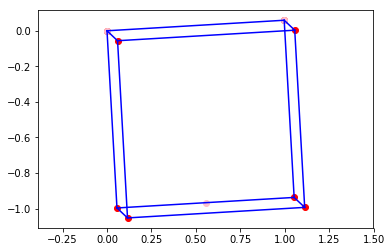

In [37]:
axis = [1,1,1]
theta = 0.1

cube(axis,theta,np.array([0,0,0]),1)